In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

In [3]:
path = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/'

In [4]:
import pandas as pd

train_df = pd.read_csv(os.path.join(path, 'my_train.csv'))
test_df = pd.read_csv(os.path.join(path, 'my_test.csv'))

In [5]:
train_df.head()

,filename,width,height,x,y,w,h,label
0,0001.jpg,640,423,20.0,75.0,521.0,298.0,1
1,0002.jpg,1992,1328,231.9,249.4,1691.6,893.7,3
2,0003.jpg,600,440,87.0,68.0,417.0,319.0,2
3,0004.jpg,1600,1065,382.5,141.0,1107.5,836.2,2
4,0005.jpg,800,450,62.5,133.2,491.9,314.4,3


In [6]:
test_df.head()

,filename,width,height,x,y,w,h,label
0,1205.jpg,640,426,230.0,76.0,388.0,259.0,1
1,1205.jpg,640,426,70.0,250.0,126.0,93.0,1
2,1205.jpg,640,426,134.0,128.0,308.0,195.0,1
3,1206.jpg,640,427,333.0,118.0,235.0,302.0,3
4,1206.jpg,640,427,137.0,85.0,150.0,315.0,3


In [7]:
train_df.groupby('filename').agg(['count'])['label']

,count
filename,
0001.jpg,1
0002.jpg,1
0003.jpg,1
0004.jpg,1
0005.jpg,3
...,...
1200.jpg,2
1201.jpg,1
1202.jpg,1


In [8]:
f_train = list(train_df['filename'].unique())

In [9]:
multi_labels = []
for f in f_train:
  labels = set(list(train_df[train_df['filename'] == f]['label']))
  
  if len(labels) > 1:
    print(f, labels)
    multi_labels.append(f)

0015.jpg {1, 3}
0037.jpg {1, 3}
0194.jpg {0, 3}
0250.jpg {1, 3}
0254.jpg {1, 3}
0393.jpg {0, 3}
0414.jpg {0, 2}
0490.jpg {0, 3}
0713.jpg {0, 3}
0763.jpg {1, 3}
0859.jpg {1, 2}
0863.jpg {0, 1}
0912.jpg {1, 2}
1030.jpg {0, 3}
1084.jpg {0, 3}
1121.jpg {0, 1, 3}


In [10]:
print(len(multi_labels))

16


In [11]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

fatal: destination path 'detr' already exists and is not an empty directory.


In [12]:
!ls

detr  drive  sample_data


In [13]:
!pip install albumentations==0.4.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

<ipython-input-14-d875a0c87f69>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [15]:
print(A.__version__)

0.4.5


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [17]:
n_folds = 5
seed = 42
num_classes = 5
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2

# Seed Everything

Seeding everything for reproducible results

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [19]:
seed_everything(seed)

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [20]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = train_df[['filename']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('filename').count()
df_folds.loc[:, 'label'] = train_df[['filename', 'label']].groupby('filename').min()['label']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['label'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
df_folds

,bbox_count,label,stratify_group,fold
filename,,,,
0001.jpg,1,1,1_0,2
0002.jpg,1,3,3_0,4
0003.jpg,1,2,2_0,1
0004.jpg,1,2,2_0,4
0005.jpg,3,3,3_0,2
...,...,...,...,...
1200.jpg,2,1,1_0,4
1201.jpg,1,0,0_0,4
1202.jpg,1,1,1_0,1


# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [22]:
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9), # RGB 임의로 shuffling
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      # https://leedakyeong.tistory.com/entry/Python-albumentations-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-Image-Agumentation,
                      A.LongestMaxSize (max_size=512),
                      A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT), 
                       
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5), # 사진의 일부를 지우고 0으로 채움
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels']) # 바운딩 박스 표기법 yolo
                      )

def get_valid_transforms():
    return A.Compose([ A.LongestMaxSize (max_size=512),
                       A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                       ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [23]:
DIR_TRAIN = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/train'

class CustomDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3] # w * h
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [24]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True) # pretrained된 DETR 모델
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [25]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [26]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

# Eval Function

In [27]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

# Engine

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [29]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = CustomDataset(
    image_ids=df_train.index.values,
    dataframe=train_df,
    transforms=get_train_transforms()
    )

    valid_dataset = CustomDataset(
    image_ids=df_valid.index.values,
    dataframe=train_df,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_{fold}.pth')

In [30]:
df_folds[df_folds['fold'] != 0].index.values[0]

'0001.jpg'

In [31]:
run(fold=0)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.6489046220937051| VALID_LOSS 1.0659610225308327|
Best model found for Fold 0 in Epoch 1........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.8565189823631413| VALID_LOSS 0.7324154578870342|
Best model found for Fold 0 in Epoch 2........Saving Model


# Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [41]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = CustomDataset(image_ids=df_valid.index.values,
                                 dataframe=train_df,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        print(p)
        if p > 0.1:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.023997296
0.029690191
0.020053027
0.02303524
0.023007607
0.027225876
0.034385163
0.025255958
0.017419688
0.016620634
0.023471868
0.020094415
0.027232112
0.020529585
0.02693263
0.024787135
0.017658856
0.020861758
0.026850652
0.020959845
0.0232655
0.027748963
0.02790374
0.018612586
0.037701882
0.03618482
0.028284915
0.022254333
0.023476735
0.024801897
0.023315182
0.02809447
0.018381454
0.023570146
0.030624494
0.02902039
0.024763258
0.024449788
0.027566519
0.029213145
0.023265662
0.019038897
0.029125031
0.025431044
0.025893848
0.019823661
0.026875308
0.030529702
0.028810129
0.028649673
0.017100798
0.02481058
0.02155628
0.02252567
0.022708815
0.028823564
0.028854705
0.031990856
0.02465777
0.020951165
0.023012765
0.022261731
0.018859182
0.025401257
0.016159838
0.024286741
0.01608466
0.028547082
0.024783088
0.030030664
0.018747812
0.032098673
0.023759458
0.027965833
0.02595468
0.033840198
0.031484786
0.01694615
0.02430222
0.020427473
0.02481412
0.028253222
0.028225109
0.01627867
0.02891192

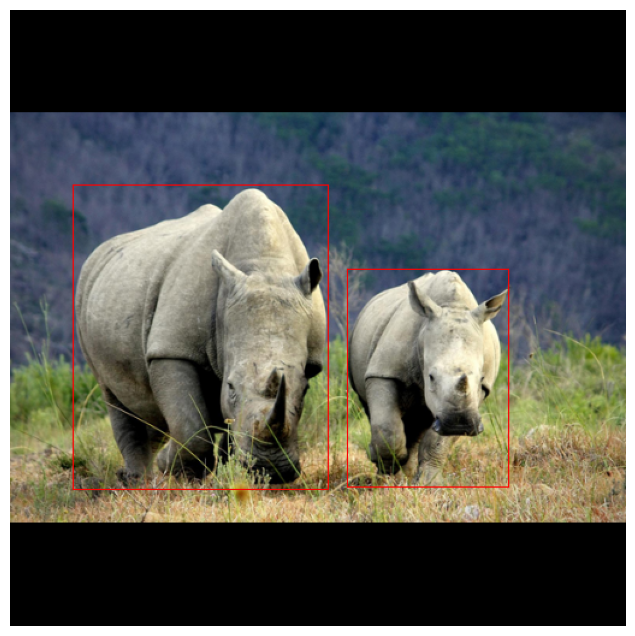

In [42]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))